### Chain
Review
We built a simple graph with nodes, normal edges, and conditional edges.

Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state
Using chat models in graph nodes
Binding tools to our chat model
Executing tool calls in graph nodes

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke(messages)
result

AIMessage(content="Orcas, also known as killer whales, can be seen in several locations along the coast of the United States. Here are a few notable places where you might have a good chance of spotting orcas:\n\n1. **Puget Sound, Washington** - The San Juan Islands within Puget Sound are particularly well-known for orca watching. The southern resident orca population spends a significant amount of time in these waters, especially from May to September. The best way to see them is by taking a guided whale-watching tour from places like Friday Harbor on San Juan Island.\n\n2. **Southeast Alaska** - The Inside Passage and Glacier Bay National Park are another excellent place to spot orcas. They can be seen in these waters year-round but are more frequently sighted during the summer months when the weather is more favorable and the days are longer. Boat tours in this region often offer the opportunity to see orcas as well as other wildlife and stunning natural scenery.\n\n3. **California 

In [27]:
def add(a:int,b:int)-> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

In [5]:
llm_with_tools=llm.bind_tools([add])

In [6]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z49q', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 173, 'total_tokens': 198, 'completion_time': 0.062801554, 'prompt_time': 0.010412756, 'queue_time': 0.024864786, 'total_time': 0.07321431}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_7b9ecfcd5f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-abd0b278-675e-47c2-91f4-783725579ada-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_z49q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 25, 'total_tokens': 198})

In [7]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_z49q',
  'type': 'tool_call'}]

In [8]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [9]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on generative ai.", name="Krish")
                   ]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_message,new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='aba4d024-efc0-484e-9a77-4401054cd9d8'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Krish', id='f9bf0eeb-fa87-4dc6-b49b-b6f1ec781ef0'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='dea90a06-451b-4639-b1e3-107ab2a51b96')]

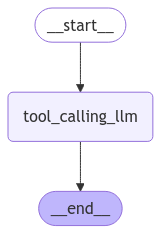

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages=graph.invoke({"messages":HumanMessage(content="What is 2 minus 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 minus 3
================================== Ai Message ==================================
Tool Calls:
  add (call_f9wh)
 Call ID: call_f9wh
  Args:
    a: 2
    b: -3


In [16]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [17]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

### Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

In [53]:
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-49fe33d6-eec0-4ea7-8a30-e86723eaf7da-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [54]:
llm_with_tools = llm.bind_tools([multiply,add])

In [55]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState




In [56]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

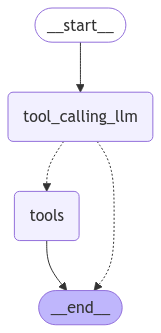

In [57]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply,add]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
#builder.add_edge("tool2", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2 and add 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2 and add 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_eabXXmQTsnQRa5FW4b4QgP9U)
 Call ID: call_eabXXmQTsnQRa5FW4b4QgP9U
  Args:
    a: 3
    b: 4
  multiply (call_xPZ4d9WDt0sgSvGtrowA0QvJ)
 Call ID: call_xPZ4d9WDt0sgSvGtrowA0QvJ
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
